# Practica APA

### Andrés Emch, Miquel Gotanegra

In [1]:
# Uncomment to upgrade packages
#!pip install pandas --user --upgrade --quiet
#!pip install numpy==1.23.5 --user --upgrade --quiet
#!pip install scipy --user --upgrade --quiet
#!pip install statsmodels --user --upgrade --quiet
#!pip install seaborn --user --upgrade --quiet
#!pip install matplotlib --user --upgrade --quiet
#!pip install scikit-learn --user --upgrade 
#!pip install imblearn --upgrade --user --quiet
#!pip install scikit-optimize --user --quiet
#!pip install dtreeviz==1.4.1 --user --upgrade  --quiet
#!pip install yellowbrick --upgrade --user --quiet
#!pip install jinja2 --upgrade
#!pip install eli5 --upgrade --user --quiet

In [1]:
import pandas as pd
from pandas import read_csv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                     f1_score, make_scorer, accuracy_score, roc_auc_score

from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.svm import LinearSVR, SVR

from sklearn.metrics import  ConfusionMatrixDisplay,\
                    classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.inspection import permutation_importance

from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier.rocauc import roc_auc
from skopt import BayesSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import  RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline, Pipeline


import eli5
from eli5.sklearn import PermutationImportance
#from dtreeviz.trees import dtreeviz

import warnings
#from apafib import load_attrition
#import skopt

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from collections import Counter

In [2]:
def save_results(clf, X_test, y_test, nclf, df):
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (W)'] = precision_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'recall score (W)'] = recall_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='weighted')
    return df

results_df = pd.DataFrame()

niter = 15
cv = 5

## Conjunto de datos

In [3]:
import pandas as pd

# df = pd.read_csv('https://download.data.world/s/e7ae526mmlubwppc4o7o2aov343rh4')
#url = 'https://drive.google.com/file/d/1ug9VUKnxh59bLEIicLVUbG5mO4sAphgq/view?usp=share_link'
#path = 'https://drive.google.com/uc?id=' + url.split('/')[-2]

df = pd.read_csv('https://raw.githubusercontent.com/andresemch/APA-FIB/main/NBA_Player_Stats.csv?token=GHSAT0AAAAAAB44OEFNTZL2PXKOKZONLJ32Y5ZOSWA')

stats_data = df[df['Year'].isin(['2020-2021','2021-2022'])]
# stats_data = df
stats_data.head()

Rk             Player Pos  Age   Tm   G  GS    MP   FG   FGA  ...  ORB  \
13074   1   Precious Achiuwa  PF   21  MIA  61   4  12.1  2.0   3.7  ...  1.2   
13075   2       Jaylen Adams  PG   24  MIL   7   0   2.6  0.1   1.1  ...  0.0   
13076   3       Steven Adams   C   27  NOP  58  58  27.7  3.3   5.3  ...  3.7   
13077   4        Bam Adebayo   C   23  MIA  64  64  33.5  7.1  12.5  ...  2.2   
13078   5  LaMarcus Aldridge   C   35  TOT  26  23  25.9  5.4  11.4  ...  0.7   

       DRB  TRB  AST  STL  BLK  TOV   PF   PTS       Year  
13074  2.2  3.4  0.5  0.3  0.5  0.7  1.5   5.0  2020-2021  
13075  0.4  0.4  0.3  0.0  0.0  0.0  0.1   0.3  2020-2021  
13076  5.2  8.9  1.9  0.9  0.7  1.3  1.9   7.6  2020-2021  
13077  6.7  9.0  5.4  1.2  1.0  2.6  2.3  18.7  2020-2021  
13078  3.8  4.5  1.9  0.4  1.1  1.0  1.8  13.5  2020-2021  

[5 rows x 31 columns]

### Selección de características


In [4]:
# stats_data = stats_data.drop(columns=['Tm','Rk','Player','FG%','3P%','2P%','eFG%','FT%','TRB'])
stats_data = stats_data.drop(columns=['Tm','Rk','Player','FG%','3P%','2P%','eFG%','FT%','TRB','Year'])
# stats_data['Pos'] = stats_data['Pos'].astype('category').cat.codes
stats_data.head()

Pos  Age   G  GS    MP   FG   FGA   3P  3PA   2P  ...   FT  FTA  ORB  \
13074  PF   21  61   4  12.1  2.0   3.7  0.0  0.0  2.0  ...  0.9  1.8  1.2   
13075  PG   24   7   0   2.6  0.1   1.1  0.0  0.3  0.1  ...  0.0  0.0  0.0   
13076   C   27  58  58  27.7  3.3   5.3  0.0  0.1  3.3  ...  1.0  2.3  3.7   
13077   C   23  64  64  33.5  7.1  12.5  0.0  0.1  7.1  ...  4.4  5.5  2.2   
13078   C   35  26  23  25.9  5.4  11.4  1.2  3.1  4.2  ...  1.6  1.8  0.7   

       DRB  AST  STL  BLK  TOV   PF   PTS  
13074  2.2  0.5  0.3  0.5  0.7  1.5   5.0  
13075  0.4  0.3  0.0  0.0  0.0  0.1   0.3  
13076  5.2  1.9  0.9  0.7  1.3  1.9   7.6  
13077  6.7  5.4  1.2  1.0  2.6  2.3  18.7  
13078  3.8  1.9  0.4  1.1  1.0  1.8  13.5  

[5 rows x 21 columns]

### Valores perdidos

In [5]:
stats_data = stats_data.replace(-1, np.nan);
stats_data = stats_data.replace(' ', np.nan);
stats_data = stats_data.replace('?', np.nan);
print('Missing Values\n',stats_data.isna().sum())

Missing Values
 Pos    0
Age    0
G      0
GS     0
MP     0
FG     0
FGA    0
3P     0
3PA    0
2P     0
2PA    0
FT     0
FTA    0
ORB    0
DRB    0
AST    0
STL    0
BLK    0
TOV    0
PF     0
PTS    0
dtype: int64


### Tratamiento de atributos categóricos

In [6]:
stats_data['Pos'].value_counts()

SG       360
PF       293
PG       274
SF       273
C        265
SF-SG      8
SG-SF      7
SG-PG      6
C-PF       4
PF-SF      3
SF-PF      3
PG-SG      2
PF-C       1
Name: Pos, dtype: int64

In [7]:
stats_data.loc[stats_data['Pos'] == 'SF-SG' ,'Pos'] = 'SF'
stats_data.loc[stats_data['Pos'] == 'SG-SF' ,'Pos'] = 'SG'
stats_data.loc[stats_data['Pos'] == 'SG-PG' ,'Pos'] = 'SG'
stats_data.loc[stats_data['Pos'] == 'C-PF' ,'Pos'] = 'C'
stats_data.loc[stats_data['Pos'] == 'PF-SF' ,'Pos'] = 'PF'
stats_data.loc[stats_data['Pos'] == 'SF-PF' ,'Pos'] = 'SF'
stats_data.loc[stats_data['Pos'] == 'PF-SF' ,'Pos'] = 'PF'
stats_data.loc[stats_data['Pos'] == 'PG-SG' ,'Pos'] = 'PG'
stats_data.loc[stats_data['Pos'] == 'PF-C' ,'Pos'] = 'PF'

In [8]:
stats_data.loc[stats_data['Pos'] == 'SG' ,'Pos'] = 'Escolta'
stats_data.loc[stats_data['Pos'] == 'PF' ,'Pos'] = 'Ala-Pivot'
stats_data.loc[stats_data['Pos'] == 'SF' ,'Pos'] = 'Alero'
stats_data.loc[stats_data['Pos'] == 'PG' ,'Pos'] = 'Base'
stats_data.loc[stats_data['Pos'] == 'C' ,'Pos'] = 'Pivot'

In [9]:
stats_data['Pos'].value_counts()

Escolta      373
Ala-Pivot    297
Alero        284
Base         276
Pivot        269
Name: Pos, dtype: int64

### Valores atípicos

In [10]:
stats_data.describe(include='all').T

count unique      top freq    mean     std   min   25%   50%    75%  \
Pos    1499      5  Escolta  373     NaN     NaN   NaN   NaN   NaN    NaN   
Age  1499.0    NaN      NaN  NaN  25.958   4.046  19.0  23.0  25.0   29.0   
G    1499.0    NaN      NaN  NaN  36.949  23.878   1.0  15.0  37.0   58.0   
GS   1499.0    NaN      NaN  NaN  16.757  22.832   0.0   0.0   5.0   27.0   
MP   1499.0    NaN      NaN  NaN  18.771   9.443   1.0  11.3  18.2  26.35   
FG   1499.0    NaN      NaN  NaN   3.002   2.256   0.0   1.3   2.5    4.1   
FGA  1499.0    NaN      NaN  NaN   6.638   4.699   0.0   3.2   5.5    9.1   
3P   1499.0    NaN      NaN  NaN   0.909   0.859   0.0   0.2   0.7    1.4   
3PA  1499.0    NaN      NaN  NaN   2.626   2.217   0.0   0.8   2.1    4.0   
2P   1499.0    NaN      NaN  NaN   2.096   1.785   0.0   0.8   1.6    2.9   
2PA  1499.0    NaN      NaN  NaN   4.016   3.256   0.0   1.5   3.2    5.5   
FT   1499.0    NaN      NaN  NaN   1.262   1.295   0.0   0.4   0.9    1.7   
FTA  1499.0    NaN      NaN  NaN   1.646    1.59   0.0   0.6   1.2    2.1   
ORB  1499.0    NaN      NaN  NaN   0.808   0.735   0.0   0.3   0.6    1.1   
DRB  1499.0    NaN      NaN  NaN    2.63   1.802   0.0   1.3   2.3    3.5   
AST  1499.0    NaN      NaN  NaN   1.863    1.83   0.0   0.6   1.3    2.4   
STL  1499.0    NaN      NaN  NaN   0.596    0.41   0.0   0.3   0.5    0.9   
BLK  1499.0    NaN      NaN  NaN   0.383   0.385   0.0   0.1   0.3    0.5   
TOV  1499.0    NaN      NaN  NaN   1.022   0.818   0.0   0.5   0.8    1.3   
PF   1499.0    NaN      NaN  NaN   1.591   0.797   0.0   1.0   1.6    2.1   
PTS  1499.0    NaN      NaN  NaN   8.173   6.225   0.0   3.5   6.8   11.1   

      max  
Pos   NaN  
Age  41.0  
G    82.0  
GS   82.0  
MP   43.5  
FG   11.4  
FGA  23.0  
3P    5.3  
3PA  12.7  
2P   10.2  
2PA  18.3  
FT    9.6  
FTA  11.8  
ORB   4.7  
DRB  11.0  
AST  11.7  
STL   2.5  
BLK   3.4  
TOV   5.0  
PF    5.0  
PTS  32.0

### Análisis final de nuestro conjunto de datos preprocesados

In [11]:
stats_data['Pos'].value_counts()

Escolta      373
Ala-Pivot    297
Alero        284
Base         276
Pivot        269
Name: Pos, dtype: int64

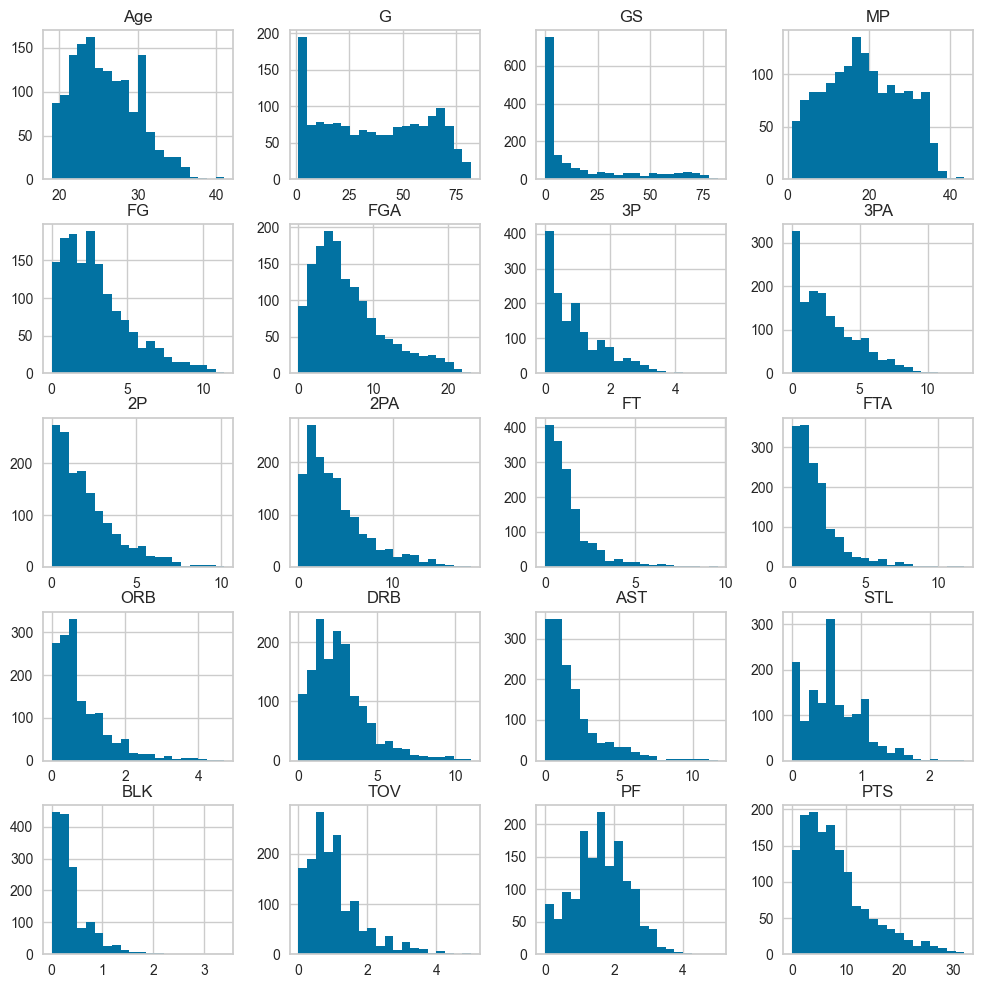

In [12]:
stats_data.loc[:,:].hist(bins=20, figsize=(12,12));

#### Matriz de correlación de las variables



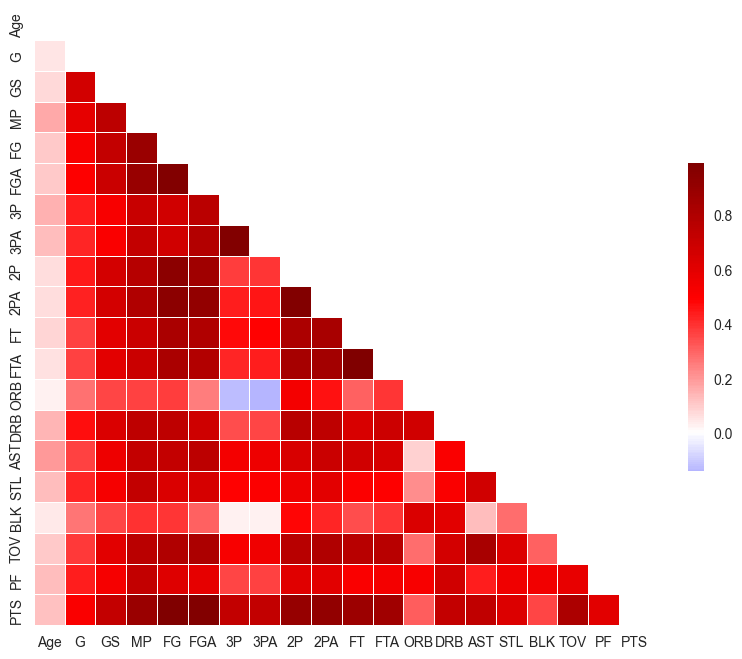

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

corr = stats_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [14]:
X_orig = stats_data.loc[:,stats_data.columns!='Pos']
y_orig = stats_data.loc[:,'Pos']

#### PCA

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
nba_std = X_train
nba_std[:] = StandardScaler().fit_transform(nba_std)
myPCA = PCA().fit(nba_std);
nba_std


Age      G     GS     MP     FG    FGA     3P    3PA     2P    2PA  \
13559  0.475 -1.385 -0.562  0.959  0.434  0.868  0.106  0.762  0.496  0.740   
13601  0.231 -0.422  0.448  1.664  1.225  1.331  1.287  1.266  0.939  1.072   
13273  0.475 -0.883 -0.299  1.140  0.785  0.868  2.232  1.494 -0.002  0.227   
13963 -1.236  0.457  0.272  0.190 -0.312 -0.227  0.106  0.076 -0.445 -0.407   
13918  1.208  0.331  1.238  1.707  1.181  1.057  1.523  1.357  0.773  0.650   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
14204  0.231 -0.129 -0.694 -1.284 -0.927 -0.963 -0.839 -0.747 -0.833 -0.890   
14368  0.475  0.331  1.063  1.450  1.400  1.415  1.760  1.357  0.939  1.133   
13934  0.475  0.289  1.194  1.215  0.522  0.952  0.815  1.128  0.274  0.589   
14533  0.231 -1.176 -0.606 -0.163 -0.751 -0.584 -0.248  0.122 -0.777 -0.920   
14200 -0.991  0.457 -0.518 -0.291 -0.576 -0.563 -0.367 -0.381 -0.556 -0.558   

          FT    FTA    ORB    DRB    AST    STL    BLK    TOV     PF    PTS  
13559  1.305  1.763 -0.004  0.090  0.858  3.006  0.311  2.968  2.177  0.605  
13601  1.682  1.454  0.134 -0.132  0.006  1.762  0.053  0.675  0.901  1.399  
13273 -0.503 -0.460 -0.694  0.201  0.645  1.762  0.570  0.192  1.284  0.764  
13963 -0.729 -0.769  0.134  0.034 -0.687  0.019  0.311 -0.170  0.263 -0.365  
13918  0.100 -0.028 -0.556  0.201  1.124  0.517 -0.464  1.037  0.773  1.081  
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  
14204 -0.654 -0.707 -0.832 -0.966 -0.846 -0.976 -0.723 -0.894 -1.524 -0.921  
14368  2.209  2.195 -0.556  0.090  0.112  0.766  0.311  0.554  1.029  1.717  
13934  1.004  1.022 -0.004  0.701  2.083  0.019 -0.464  0.796  1.029  0.700  
14533 -0.880 -0.892 -0.694  0.034 -0.527 -0.728 -0.206 -0.773 -0.631 -0.762  
14200 -0.579 -0.460 -0.280 -0.577 -0.793 -0.230 -0.206 -0.894 -0.758 -0.587  

[1049 rows x 20 columns]

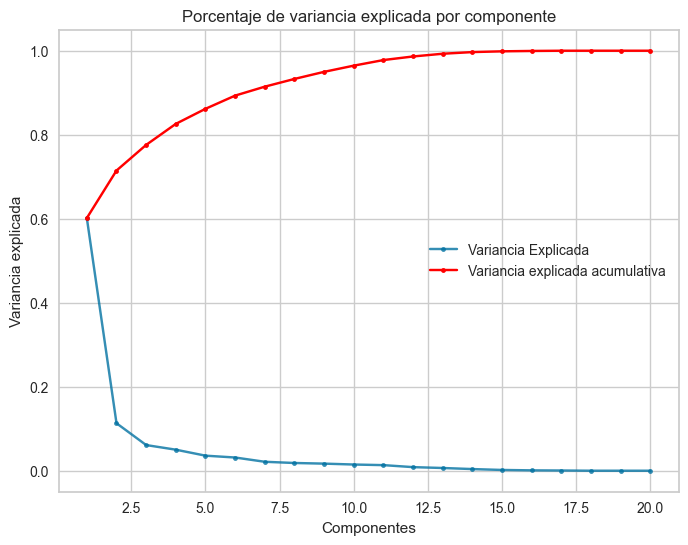

In [16]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),myPCA.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),
         np.cumsum(myPCA.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

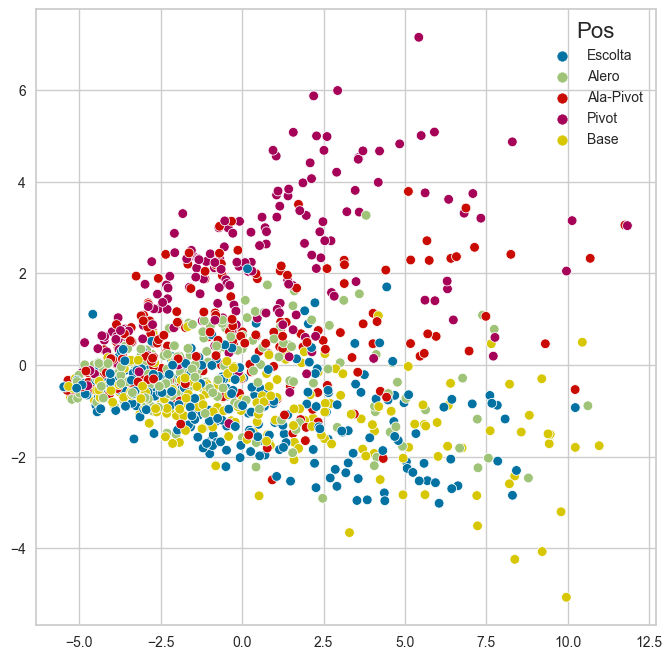

In [17]:
nba_pca = myPCA.transform(nba_std)
plt.figure(figsize=(8,8));
sns.scatterplot(x=nba_pca[:,0], y=nba_pca[:,1], hue=y_train);

In [18]:
stats_data.loc[stats_data['Pos'] == 'Escolta' ,'Pos'] = 'Base/Escolta'
stats_data.loc[stats_data['Pos'] == 'Ala-Pivot' ,'Pos'] = 'Alero'
stats_data.loc[stats_data['Pos'] == 'Alero' ,'Pos'] = 'Alero'
stats_data.loc[stats_data['Pos'] == 'Base' ,'Pos'] = 'Base/Escolta'
stats_data.loc[stats_data['Pos'] == 'Pivot' ,'Pos'] = 'Pivot'

<Figure size 800x600 with 0 Axes>

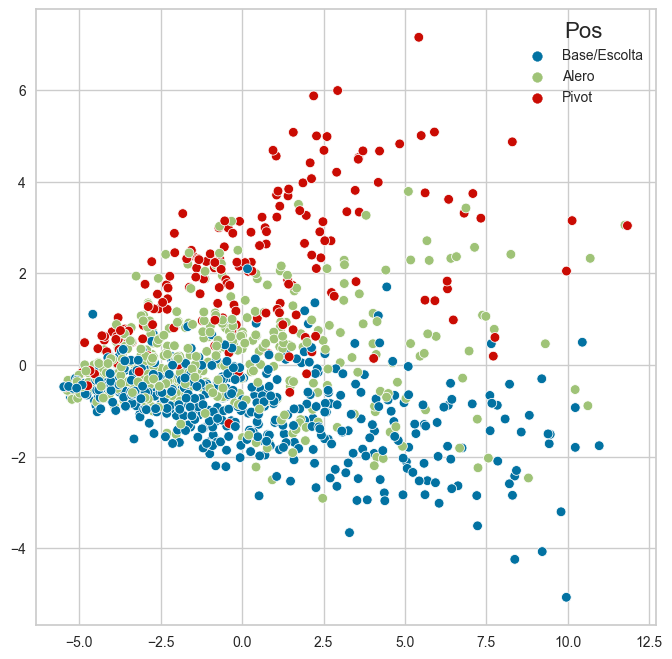

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
fig = plt.figure(figsize=(8,6));
plt.figure(figsize=(8,8));
sns.scatterplot(x=nba_pca[:,0], y=nba_pca[:,1], hue=y_train);

### División entrenamiento-prueba

In [20]:
X_orig = stats_data.loc[:,stats_data.columns!='Pos']
y_orig = stats_data.loc[:,'Pos']

X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
print(y_train.value_counts())

Base/Escolta    460
Alero           408
Pivot           181
Name: Pos, dtype: int64


In [21]:
print(y_test.value_counts())

Base/Escolta    189
Alero           173
Pivot            88
Name: Pos, dtype: int64


In [22]:
smt = SMOTE(random_state=0)
X_train, y_train = smt.fit_resample(X_train, y_train)

undersample = RandomUnderSampler(sampling_strategy='majority',random_state=0)
X_test, y_test = undersample.fit_resample(X_test,y_test)
X_test, y_test = undersample.fit_resample(X_test,y_test)

In [23]:
y_train.value_counts()

Base/Escolta    460
Alero           460
Pivot           460
Name: Pos, dtype: int64

In [24]:
y_test.value_counts()

Alero           88
Base/Escolta    88
Pivot           88
Name: Pos, dtype: int64

#### Normalizamos los datos

In [25]:
scaler = MinMaxScaler();
X_train = scaler.fit_transform(X_train);
X_test = scaler.transform(X_test);

### Clasificadores lineales/cuadráticos

#### Linear Discriminant Analysis (LDA)

In [26]:
lda = LinearDiscriminantAnalysis()

print("Validación cruzada del método LDA:")
print(np.mean(cross_val_score(lda,X_train,y_train,cv=10)))

Validación cruzada del método LDA:
0.7318840579710144


Original:
Priors: [0.33333333 0.33333333 0.33333333]
Means:

Intercepts:
Explained Variance Ratio
Coefs:


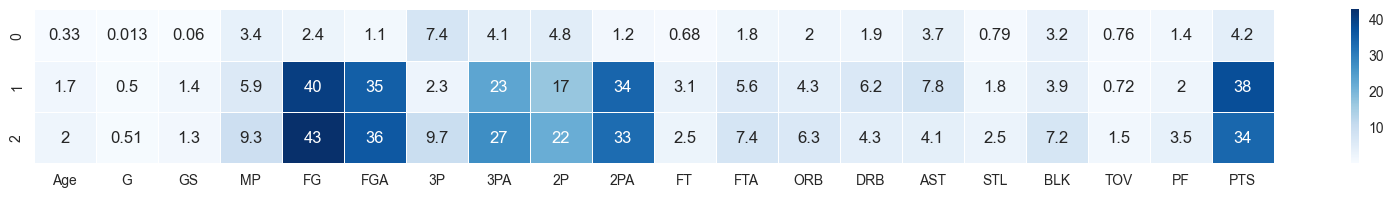

In [27]:
lda_model_orig = LinearDiscriminantAnalysis().fit(X_train, y_train)

print('Original:')
print('Priors:', lda_model_orig.priors_)
print('Means:\n')
means_orig =pd.DataFrame(lda_model_orig.means_)
means_orig.columns=X_orig.columns
means_orig


print('Intercepts:')
intercepts_orig = pd.DataFrame(lda_model_orig.intercept_)
intercepts_orig

print('Explained Variance Ratio')
pd.DataFrame(lda_model_orig.explained_variance_ratio_ )

print('Coefs:')
coefs_orig = pd.DataFrame(lda_model_orig.coef_)
coefs_orig.columns = X_orig.columns

plt.figure(figsize=(20,2));
sns.heatmap(coefs_orig.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

In [28]:
perm = PermutationImportance(lda_model_orig, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = stats_data.loc[:,stats_data.columns!='Pos'].columns.tolist())

In [29]:

print(classification_report(lda_model_orig.predict(X_test), y_test))
results_df = save_results(lda_model_orig, X_test, y_test, 'LDA', results_df)

              precision    recall  f1-score   support

       Alero       0.68      0.54      0.60       111
Base/Escolta       0.67      0.80      0.73        74
       Pivot       0.75      0.84      0.79        79

    accuracy                           0.70       264
   macro avg       0.70      0.72      0.71       264
weighted avg       0.70      0.70      0.69       264



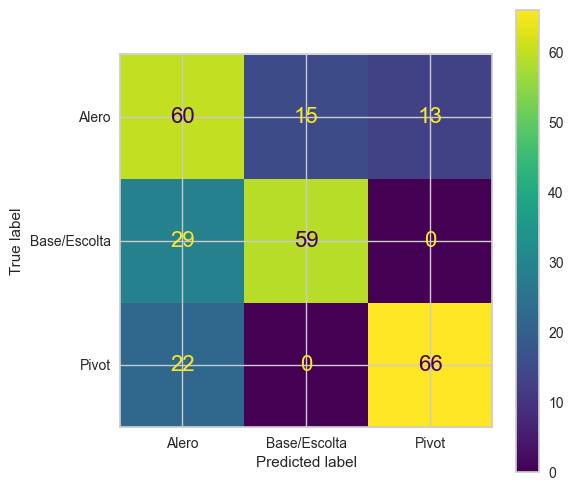

In [30]:
plt.figure(figsize=(6,6));
ConfusionMatrixDisplay.from_estimator(lda_model_orig, X_test,y_test, ax=plt.subplot());

#### Quadrant Discriminant Analysis (QDA)

In [31]:
qda = QuadraticDiscriminantAnalysis()

print("Validación cruzada del método QDA:")
print(np.mean(cross_val_score(qda,X_train,y_train,cv=10)))

Validación cruzada del método QDA:
0.7471014492753624


In [32]:
qda_model = qda.fit(X_train,y_train)
print('Priors:', qda.priors_)
print('Means:\n')
means = pd.DataFrame(qda_model.means_)
means.columns=X_orig.columns
means['Pos'] = qda_model.classes_
means.loc[:,['Pos']+X_orig.columns.to_list()]

Priors: [0.33333333 0.33333333 0.33333333]
Means:



Pos    Age      G     GS     MP     FG    FGA     3P    3PA  \
0         Alero  0.323  0.434  0.198  0.402  0.241  0.264  0.159  0.195   
1  Base/Escolta  0.331  0.446  0.202  0.444  0.284  0.330  0.221  0.264   
2         Pivot  0.350  0.458  0.263  0.405  0.276  0.257  0.075  0.092   

      2P  ...     FT    FTA    ORB    DRB    AST    STL    BLK    TOV     PF  \
0  0.201  ...  0.122  0.131  0.178  0.273  0.118  0.247  0.109  0.176  0.385   
1  0.217  ...  0.138  0.139  0.095  0.217  0.224  0.306  0.068  0.240  0.373   
2  0.290  ...  0.141  0.162  0.353  0.384  0.106  0.232  0.233  0.210  0.498   

     PTS  
0  0.235  
1  0.280  
2  0.251  

[3 rows x 21 columns]

In [33]:
perm = PermutationImportance(qda_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = stats_data.loc[:,stats_data.columns!='Pos'].columns.tolist())

In [34]:
y_pred = qda_model.predict(X_test)
print(classification_report(qda_model.predict(X_test), y_test))
print('fitted cross_val of qda: ' + str(np.mean(cross_val_score(qda_model,X_train,y_train,cv=10))))
results_df = save_results(qda_model, X_test, y_test, 'QDA', results_df)

              precision    recall  f1-score   support

       Alero       0.70      0.60      0.65       104
Base/Escolta       0.76      0.82      0.79        82
       Pivot       0.73      0.82      0.77        78

    accuracy                           0.73       264
   macro avg       0.73      0.74      0.74       264
weighted avg       0.73      0.73      0.73       264

fitted cross_val of qda: 0.7471014492753624


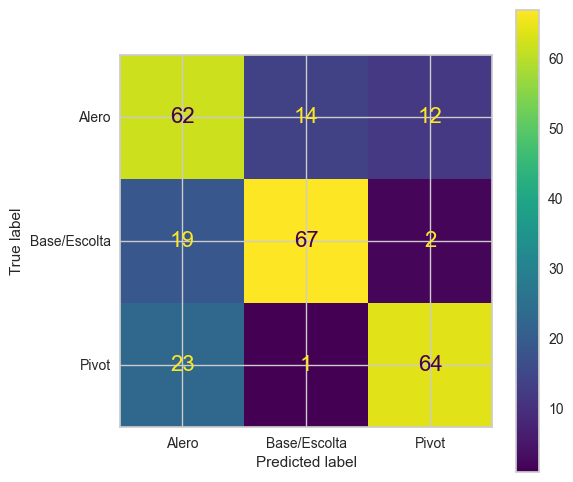

In [35]:
plt.figure(figsize=(6,6));
ConfusionMatrixDisplay.from_estimator(qda_model, X_test,y_test, ax=plt.subplot());

### K Nearest Neighbors (KNN)

In [36]:
knn_val =  KNeighborsClassifier()

print("Validación cruzada del método KNN:")
print(np.mean(cross_val_score(knn_val,X_train,y_train,cv=10)))

Validación cruzada del método KNN:
0.7195652173913043


Text(0, 0.5, 'Accuracy')

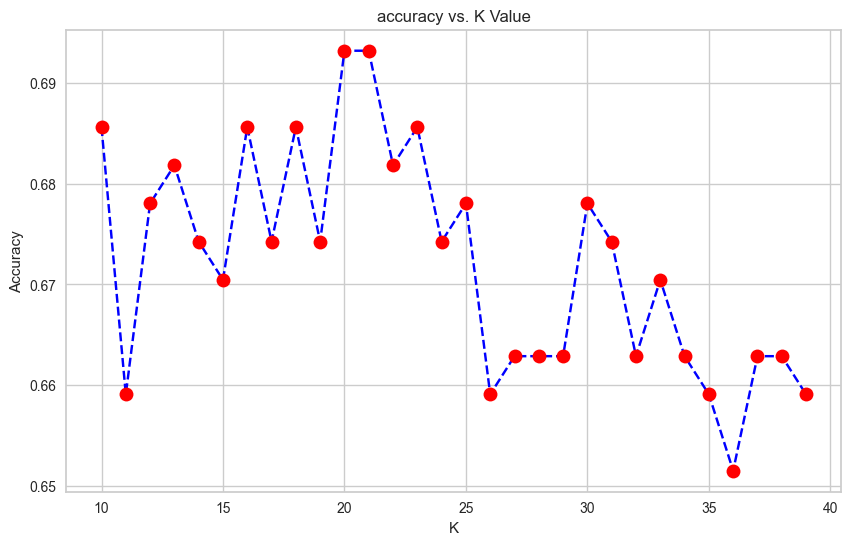

In [37]:
acc = []
from sklearn import metrics
for i in range(10,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))

plt.figure(figsize=(10,6))
plt.plot(range(10,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')

In [38]:
ks = [11,12,13,14,15,16]
metrics = ['euclidean', 'manhattan', 'mahalanobis', 'minkowski']

model_knn = KNeighborsClassifier()

knn = GridSearchCV(estimator=model_knn,
                   param_grid={'n_neighbors':ks,
                               'metric':metrics
                   },
                   scoring=['accuracy', 'recall_macro'],
                   cv=5,
                   return_train_score=True,
                  refit='recall_macro')

model_4CV = knn.fit(X_train, y_train)
model_4CV.best_score_
model_4CV.best_params_

{'metric': 'manhattan', 'n_neighbors': 14}

In [39]:
knn =  KNeighborsClassifier(n_neighbors=14, metric='mnhattan')
param = {'n_neighbors':[1, 3, 5, 7, 11, 15], 
          'weights':['distance', 'uniform'], 
          'leaf_size':[1, 5, 10, 20, 30],
          'metric': ['l2', 'l1', 'cosine']}

knn_gs =  GridSearchCV(knn,param,cv=10, n_jobs=-1)
knn_gs.fit(X_train, y_train);

In [40]:
print('fitted cross_val of knn_gs: ' + str(np.mean(cross_val_score(knn_gs,X_train,y_train,cv=10))))

fitted cross_val of knn_gs: 0.8057971014492754


In [41]:
perm = PermutationImportance(knn_gs, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = stats_data.loc[:,stats_data.columns!='Pos'].columns.tolist())

In [42]:
print(classification_report(knn_gs.predict(X_test), y_test))
results_df = save_results(knn_gs, X_test, y_test, 'KNN', results_df)

              precision    recall  f1-score   support

       Alero       0.60      0.61      0.61        87
Base/Escolta       0.77      0.71      0.74        96
       Pivot       0.75      0.81      0.78        81

    accuracy                           0.71       264
   macro avg       0.71      0.71      0.71       264
weighted avg       0.71      0.71      0.71       264



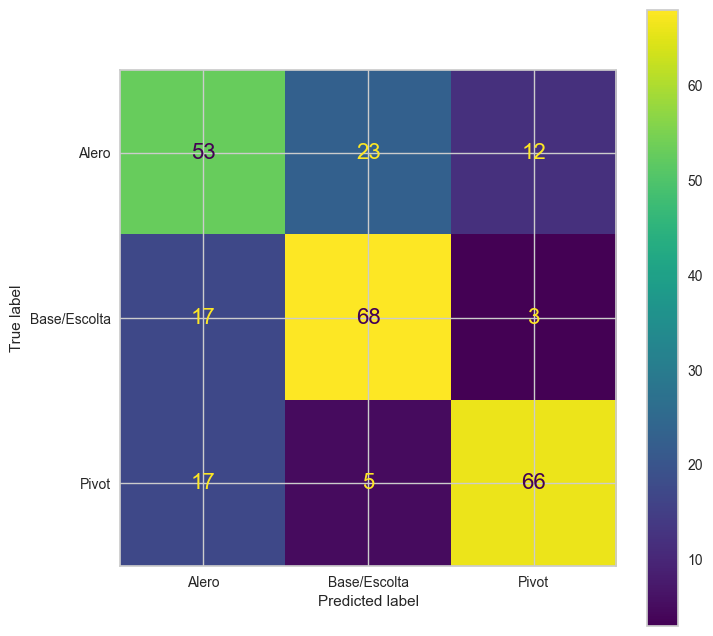

In [43]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(knn_gs, X_test,y_test, ax=plt.subplot());

### Support Vector Machine con kernel lineal (SVM)

In [44]:
svm_val =  SVC()

print("Validación cruzada del método SVM:")
print(np.mean(cross_val_score(svm_val,X_train,y_train,cv=10)))

Validación cruzada del método SVM:
0.7789855072463767


In [45]:
svm = SVC()
Cs = [0.1,1, 10, 100]
kernels = ['linear', 'rbf']
trc = GridSearchCV(estimator=svm,
                   param_grid={ 
                       'C': Cs,
                       'kernel': kernels
                    },
                   scoring=['accuracy', 'recall_macro', 'f1_macro'],
                   cv=5,
                   return_train_score=True,
                   refit='f1_macro')

model_3CV = trc.fit(X_train, y_train)
model_3CV.best_score_
model_3CV.best_params_

{'C': 10, 'kernel': 'rbf'}

In [46]:
svm = SVC(kernel='linear',class_weight='balanced', C=100)
svm.fit(X_train,y_train)

scores = cross_val_score(svm, X_test, y_test, cv=10)
scores_recall = cross_val_score(svm, X_test, y_test, cv=10,scoring='recall_macro')
scores_f_score = cross_val_score(svm, X_test, y_test, cv=10,scoring='f1_macro')

print('F-score (mean): ')
np.mean(scores_f_score)

y_pred = svm.predict(X_test)
print(classification_report(y_test,y_pred))
results_df = save_results(svm, X_test, y_test, 'SVM con kernel lineal', results_df)
print('fitted cross_val of svm_fit: ' + str(np.mean(cross_val_score(svm,X_train,y_train,cv=10))))

F-score (mean): 
              precision    recall  f1-score   support

       Alero       0.63      0.65      0.64        88
Base/Escolta       0.81      0.83      0.82        88
       Pivot       0.81      0.76      0.78        88

    accuracy                           0.75       264
   macro avg       0.75      0.75      0.75       264
weighted avg       0.75      0.75      0.75       264

fitted cross_val of svm_fit: 0.7695652173913043


In [47]:
perm = PermutationImportance(svm, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = stats_data.loc[:,stats_data.columns!='Pos'].columns.tolist())

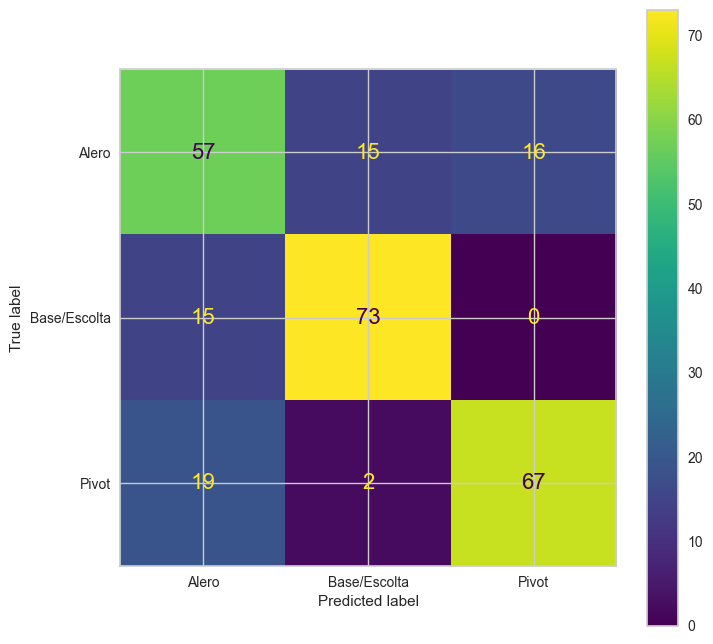

In [48]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(svm, X_test,y_test, ax=plt.subplot());

###  Prueba de clasificadores no lineales

#### MLP

In [49]:
mlp = MLPClassifier();
print('non fitted cross_val of mlp: ' + str(np.mean(cross_val_score(mlp,X_train,y_train,cv=10))));

non fitted cross_val of mlp: 0.7797101449275362


In [50]:
param = {'hidden_layer_sizes':[10, 50, 100, 200, 300,500], 
'activation':['relu', 'identity', 'logistic'], 
'alpha':[0.0001, 0.001, 0.01,0.1],
'momentum': [0.95, 0.90, 0.85, 0.8,0.7], 
'learning_rate_init': [0.001, 0.01, 0.1],
'n_iter_no_change':[10, 20, 40, 50], 
'learning_rate': ['constant', 'invscaling', 'adaptive']}

mlp =  MLPClassifier(max_iter=10000,early_stopping=True,random_state=0)
mlp_bs =  BayesSearchCV(mlp,param,
                        n_iter=15, 
                        cv=5, n_jobs=-1, 
                        refit=True,random_state=0)
mlp_bs.fit(X_train, y_train);


In [51]:
show_html(pd.DataFrame(mlp_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

In [52]:
perm = PermutationImportance(mlp_bs, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = stats_data.loc[:,stats_data.columns!='Pos'].columns.tolist())

In [53]:
mlp_fit = mlp_bs.best_estimator_
mlp_fit.fit(X_train,y_train);
print('fitted cross_val of mlp_fit: ' + str(np.mean(cross_val_score(mlp_fit,X_train,y_train,cv=10))))


fitted cross_val of mlp_fit: 0.7753623188405797


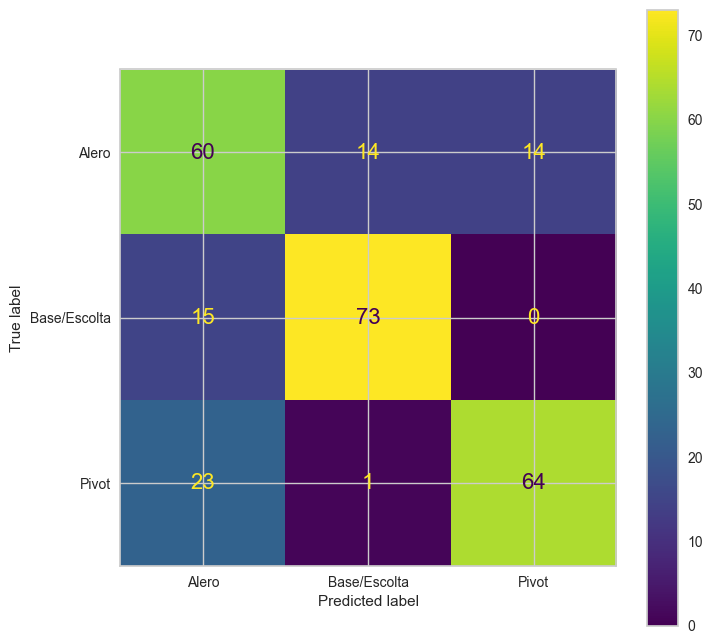

In [54]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(mlp_fit, X_test,y_test, ax=plt.subplot());

In [55]:
print(classification_report(mlp_fit.predict(X_test), y_test))
results_df = save_results(mlp_fit, X_test, y_test, 'MLP', results_df)

              precision    recall  f1-score   support

       Alero       0.68      0.61      0.65        98
Base/Escolta       0.83      0.83      0.83        88
       Pivot       0.73      0.82      0.77        78

    accuracy                           0.75       264
   macro avg       0.75      0.75      0.75       264
weighted avg       0.74      0.75      0.74       264



#### SVM con kernel RBF

In [56]:
param = {'C':10**np.linspace(-3,3,101), 'gamma':['scale','auto']}

rbsvc =  SVC(kernel='rbf', max_iter=25000, random_state=0,class_weight='balanced')
rbsvc_gs = BayesSearchCV(rbsvc,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
rbsvc_gs.fit(X_train, y_train);
show_html(pd.DataFrame(rbsvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

In [57]:
perm = PermutationImportance(rbsvc_gs, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = stats_data.loc[:,stats_data.columns!='Pos'].columns.tolist())

In [58]:
svmRBF = rbsvc_gs.best_estimator_
svmRBF.fit(X_train,y_train);
print('fitted cross_val of svmRBF: ' + str(np.mean(cross_val_score(svmRBF,X_train,y_train,cv=10))))


fitted cross_val of svmRBF: 0.7985507246376812


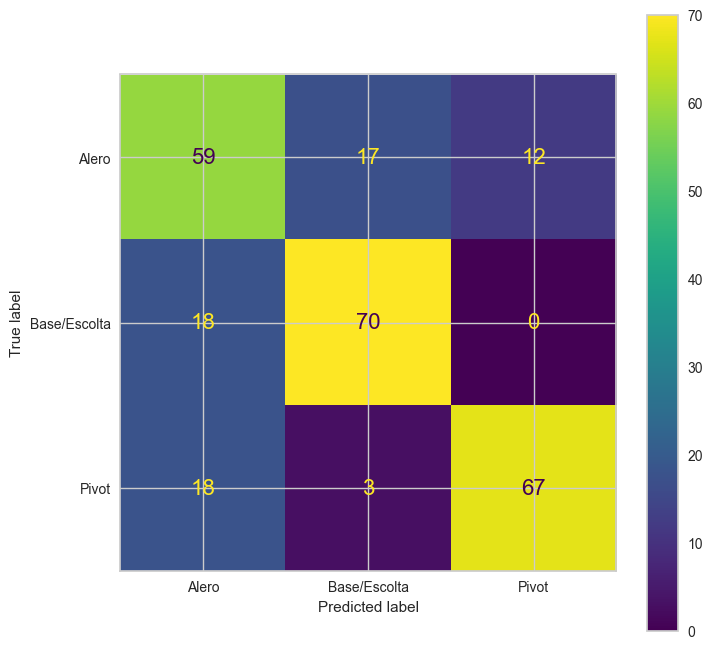

In [59]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(svmRBF, X_test,y_test, ax=plt.subplot());

In [60]:
print(classification_report(svmRBF.predict(X_test), y_test))
results_df = save_results(svmRBF, X_test, y_test, 'SVM con kernel RBF', results_df)

              precision    recall  f1-score   support

       Alero       0.67      0.62      0.64        95
Base/Escolta       0.80      0.78      0.79        90
       Pivot       0.76      0.85      0.80        79

    accuracy                           0.74       264
   macro avg       0.74      0.75      0.74       264
weighted avg       0.74      0.74      0.74       264



#### Gradient Boosting

In [61]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'loss':['log_loss'], ##exponential no acepta mas de dos classes
         'criterion':['friedman_mse', 'squared_error'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10], 
         'learning_rate':[0.1,0.5, 1,3, 5, 10, 15]}

gb =  GradientBoostingClassifier(random_state=0,n_iter_no_change=5)
gb_bs =  BayesSearchCV(gb,param,n_iter=40, cv=10, n_jobs=-1, refit=True, random_state=0)
gb_bs.fit(X_train, y_train);

In [ ]:
perm = PermutationImportance(gb_bs, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = stats_data.loc[:,stats_data.columns!='Pos'].columns.tolist())

In [ ]:
show_html(pd.DataFrame(gb_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

fitted cross_val of gradient boosing: 0.8137681159420289
              precision    recall  f1-score   support

       Alero       0.62      0.61      0.62        90
Base/Escolta       0.84      0.73      0.78       101
       Pivot       0.69      0.84      0.76        73

    accuracy                           0.72       264
   macro avg       0.72      0.73      0.72       264
weighted avg       0.73      0.72      0.72       264



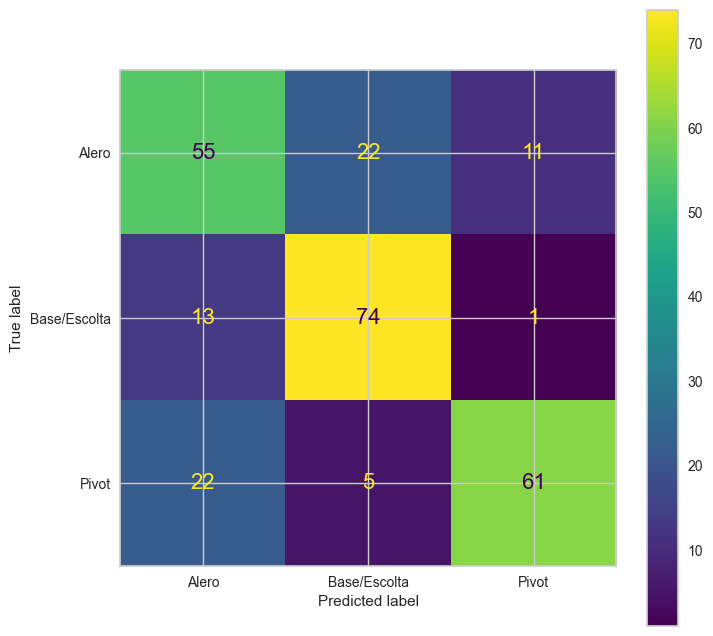

In [ ]:
gradBoosting = gb_bs.best_estimator_
gradBoosting.fit(X_train,y_train);
print('fitted cross_val of gradient boosing: ' + str(np.mean(cross_val_score(gradBoosting,X_train,y_train,cv=10))))
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gradBoosting, X_test,y_test, ax=plt.subplot());
print(classification_report(gradBoosting.predict(X_test), y_test))
results_df = save_results(gradBoosting, X_test, y_test, 'Gradient Boosting', results_df)

#### Ensembles

In [ ]:
results_df.sort_values(by=['test acc'], ascending=False)

test acc  precision score (W)  recall score (W)  \
SVM con kernel lineal     0.746                0.748             0.746   
MLP                       0.746                0.754             0.746   
SVM con kernel RBF        0.742                0.749             0.742   
QDA                       0.731                0.745             0.731   
Gradient Boosting         0.720                0.726             0.720   
KNN                       0.708                0.711             0.708   
LDA                       0.701                0.724             0.701   

                       f1 score (W)  
SVM con kernel lineal         0.747  
MLP                           0.749  
SVM con kernel RBF            0.745  
QDA                           0.735  
Gradient Boosting             0.720  
KNN                           0.709  
LDA                           0.707

In [ ]:
vs = VotingClassifier([('rbf', rbsvc_gs.best_estimator_),
                        ('mlp', mlp_bs.best_estimator_),
                        ('qda',qda_model)],voting='hard', n_jobs=1)
print(np.mean(cross_val_score(vs,X_train,y_train,cv=5)))                             
vs.fit(X_train, y_train); 
print('fitted cross_val of voting: ' + str(np.mean(cross_val_score(vs,X_train,y_train,cv=10))))
print(classification_report(vs.predict(X_test), y_test))
results_df = save_results(vs, X_test, y_test, 'Voting RBF+MLP+QDA', results_df)

0.782608695652174
fitted cross_val of voting: 0.7891304347826086
              precision    recall  f1-score   support

       Alero       0.69      0.63      0.66        97
Base/Escolta       0.83      0.83      0.83        88
       Pivot       0.75      0.84      0.79        79

    accuracy                           0.76       264
   macro avg       0.76      0.76      0.76       264
weighted avg       0.76      0.76      0.76       264



In [ ]:
perm = PermutationImportance(vs, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = stats_data.loc[:,stats_data.columns!='Pos'].columns.tolist())

In [ ]:
results_df.sort_values(by=['test acc'], ascending=False)

test acc  precision score (W)  recall score (W)  \
Voting RBF+MLP+QDA        0.758                0.765             0.758   
SVM con kernel lineal     0.746                0.748             0.746   
MLP                       0.746                0.754             0.746   
SVM con kernel RBF        0.742                0.749             0.742   
QDA                       0.731                0.745             0.731   
Gradient Boosting         0.720                0.726             0.720   
KNN                       0.708                0.711             0.708   
LDA                       0.701                0.724             0.701   

                       f1 score (W)  
Voting RBF+MLP+QDA            0.760  
SVM con kernel lineal         0.747  
MLP                           0.749  
SVM con kernel RBF            0.745  
QDA                           0.735  
Gradient Boosting             0.720  
KNN                           0.709  
LDA                           0.707